In [1]:
#import packages
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from itertools import product

#hyperparameters

#N_EPOCHS was increased to improve model performance
SEQ_LEN = 20
BATCH_SIZE = 32
N_EPOCHS = 30

#seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#define model, using GRU as it was best in single variate case
class StockGRU3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=3):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

#create sequences aligns all the data
def create_sequences(data, seq_len, target_indices):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_indices])
    return np.array(X), np.array(y)

In [3]:
#reading and splitting of data
def load_index(path, prefix):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
    df = df.sort_values("Date")
    df = df[["Date", "Close/Last", "Open", "High", "Low"]]
    df.columns = ["Date"] + [f"{prefix}_{col}" for col in df.columns[1:]]
    return df

sap = load_index("S&P500 5Y.csv", "SAP")
nas = load_index("NASDAQ-100 (NDX) Historical Data 5Y.csv", "NASDAQ")
dow = load_index("Dow Jones Industrial Average Historical Data 5Y.csv", "DJ")

merged_df = sap.merge(nas, on="Date").merge(dow, on="Date")

features = [col for col in merged_df.columns if col != "Date"]

In [4]:
#prepping data

#values normalized between 0 and 1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(merged_df[features])

#define targets
target_cols = ["SAP_Close/Last", "NASDAQ_Close/Last", "DJ_Close/Last"]
target_indices = [features.index(col) for col in target_cols]

X, y = create_sequences(scaled, SEQ_LEN, target_indices)
dates = merged_df["Date"][SEQ_LEN:].reset_index(drop=True)

#define test and train sets, don't need to unsqueeze this time
train_idx = dates.dt.year <= 2023
test_idx = dates.dt.year == 2024

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [5]:
#hyperparameters
hidden_sizes = [32, 64, 128, 256]
learning_rates = [0.0005, 0.001, 0.005, 0.01]
num_layers_list = [1, 2, 3]

grid = list(product(hidden_sizes, learning_rates, num_layers_list))

best_configs = {}
model_results = {}

for i, target_idx in enumerate(target_indices):
    feature_name = features[target_idx]
    y_train_i_tensor = torch.tensor(y_train[:, i], dtype=torch.float32).to(device)
    y_test_i = y_test[:, i]

    best_rmse = float("inf")
    best_result = None
    model_results[i] = {}

    pad_actual = np.zeros((len(y_test_i), len(features)))
    pad_actual[:, target_idx] = y_test_i

    actual_unscaled = scaler.inverse_transform(pad_actual)[:, target_idx]
    model_results[i]["actual"] = actual_unscaled
    
    gen = torch.Generator().manual_seed(12)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_i_tensor), batch_size=BATCH_SIZE, shuffle=True, generator=gen)

    for H, LR, L in grid:
        model = StockGRU3(input_size=X_train_tensor.shape[2], hidden_size=H, num_layers=L, output_size=1).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        loss_fn = nn.MSELoss()

        for epoch in range(N_EPOCHS):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb).squeeze()
                loss = loss_fn(preds, yb)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor.to(device)).squeeze().cpu().numpy()

        pad_pred = np.zeros((len(y_pred), len(features)))
        pad_pred[:, target_idx] = y_pred

        y_pred_unscaled = scaler.inverse_transform(pad_pred)[:, target_idx]
        val_rmse = root_mean_squared_error(actual_unscaled, y_pred_unscaled)
        label = f"H{H}_LR{LR}_L{L}"

        model_results[i][label] = {
            "label": label,
            "pred": y_pred_unscaled,
            "rmse": val_rmse
        }

        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_result = {
                "label": label,
                "H": H,
                "LR": LR,
                "L": L,
                "rmse": val_rmse
            }

    best_configs[i] = best_result

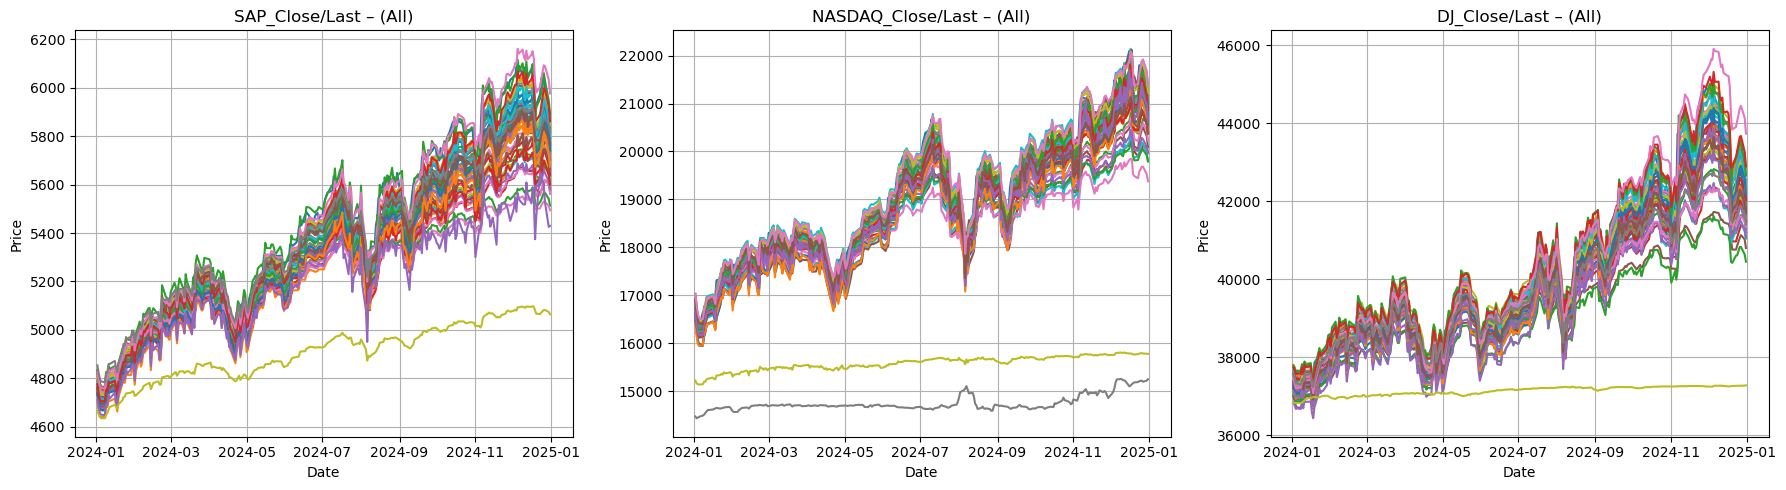

In [6]:
#plot all
fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 5), sharex=True)

for i, target_idx in enumerate(target_indices):
    feature_name = features[target_idx]
    ax = axs[i]
    ax.plot(dates[test_idx], model_results[i]["actual"])
            #, label=f"Actual {feature_name}", color="black", linewidth=2)

    for label, data in model_results[i].items():
        if label == "actual":
            continue
        ax.plot(dates[test_idx], data["pred"])
                #, label=f"{data['label']} (RMSE={data['rmse']:.2f})", alpha=0.6)

    ax.set_title(f"{feature_name} – (All)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True)
    #ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

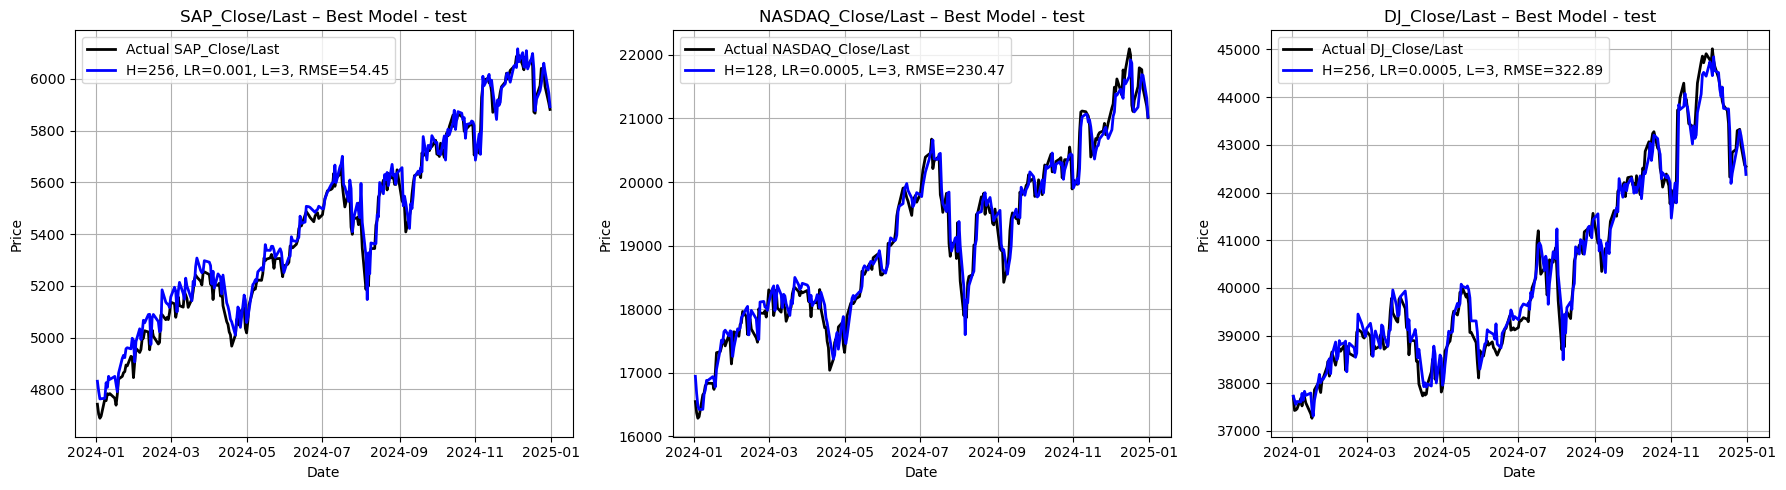

In [7]:
#plot best only
fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 5), sharex=True)

for i, target_idx in enumerate(target_indices):
    feature_name = features[target_idx]
    ax = axs[i]
    actual = model_results[i]["actual"]
    best_label = best_configs[i]["label"]
    best_pred = model_results[i][best_label]["pred"]
    best_rmse = model_results[i][best_label]["rmse"]

    H = best_configs[i]["H"]
    LR = best_configs[i]["LR"]
    L = best_configs[i]["L"]
    
    legend_label = f"H={H}, LR={LR}, L={L}, RMSE={best_rmse:.2f}"
    
    ax.plot(dates[test_idx], actual, label=f"Actual {feature_name}", color="black", linewidth=2)
    ax.plot(dates[test_idx], best_pred,
            label=legend_label, color="blue", linewidth=2)

    ax.set_title(f"{feature_name} – Best Model - test")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [8]:
#re prep data for validation

scaler = MinMaxScaler()
scaled = scaler.fit_transform(merged_df[features])

target_cols = ["SAP_Close/Last", "NASDAQ_Close/Last", "DJ_Close/Last"]
target_indices = [features.index(col) for col in target_cols]

X, y = create_sequences(scaled, SEQ_LEN, target_indices)
dates = merged_df["Date"][SEQ_LEN:].reset_index(drop=True)

trainval_idx = dates.dt.year <= 2024
val_idx = dates.dt.year == 2025

# Convert to tensors
X_trainval_tensor = torch.tensor(X[trainval_idx], dtype=torch.float32).to(device)
y_trainval_tensor = torch.tensor(y[trainval_idx], dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X[val_idx], dtype=torch.float32).to(device)
y_val = y[val_idx]

In [9]:
val_results = {}

for i, target_idx in enumerate(target_indices):
    feature_name = features[target_idx]

    cfg = best_configs[i]
    H = cfg["H"]
    LR = cfg["LR"]
    L = cfg["L"]

    # Prepare training and validation targets
    y_trainval_i = y_trainval_tensor[:, i]
    y_val_i = y_val[:, i]

    # Define model
    model = StockGRU3(input_size=X_trainval_tensor.shape[2], hidden_size=H, num_layers=L, output_size=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    gen=torch.Generator().manual_seed(12)
    train_loader = DataLoader(TensorDataset(X_trainval_tensor, y_trainval_i), batch_size=BATCH_SIZE, shuffle=True, generator=gen)

    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    #predictions/evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_tensor.to(device)).squeeze().cpu().numpy()

    # Unscale predictions and actuals
    pad_pred = np.zeros((len(y_pred), len(features)))
    pad_actual = np.zeros((len(y_val_i), len(features)))
    pad_pred[:, target_idx] = y_pred
    pad_actual[:, target_idx] = y_val_i

    y_pred_unscaled = scaler.inverse_transform(pad_pred)[:, target_idx]
    y_actual_unscaled = scaler.inverse_transform(pad_actual)[:, target_idx]

    val_rmse = root_mean_squared_error(y_actual_unscaled, y_pred_unscaled)

    val_results[i] = {
        "feature": feature_name,
        "pred": y_pred_unscaled,
        "actual": y_actual_unscaled,
        "rmse": val_rmse,
        "H": H,
        "LR": LR,
        "L": L
    }

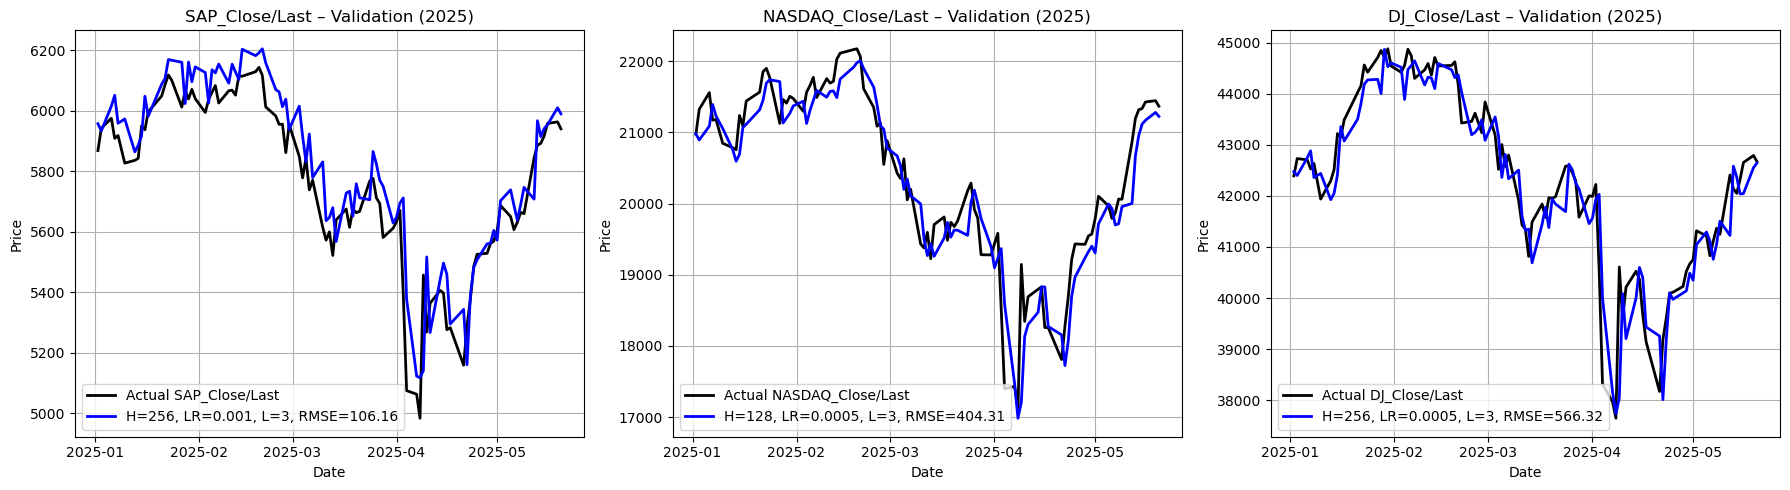

In [10]:
#plot final
fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 5), sharex=True)

for i, target_idx in enumerate(target_indices):
    result = val_results[i]
    feature_name = result["feature"]
    ax = axs[i]

    H = result["H"]
    LR = result["LR"]
    L = result["L"] 
    rmse = result["rmse"]
    
    legend_label = f"H={H}, LR={LR}, L={L}, RMSE={rmse:.2f}"
    
    ax.plot(dates[val_idx], result["actual"],
            label=f"Actual {feature_name}", color="black", linewidth=2)

    ax.plot(dates[val_idx], result["pred"],
            label=legend_label, color="blue", linewidth=2)

    ax.set_title(f"{feature_name} – Validation (2025)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()